# Imports

This script loads the fitted resonator data from 'res_fit_results.csv'. Fit results were obtained using the dispersive shift data sets within data folders 20231110, 20231111, 20231112, 20231113 with the resonator fitting model within the Superconducting Qubit Tools library from Orange Quantum Systems. 

In [1]:
import numpy as np
import qutip as qtp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *
%matplotlib inline
import pandas as pd

import scqubits as scq
from scipy import constants
from scipy import interpolate
import scipy

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import h5py
import json
import os
from pathlib import Path
from quantify_core.data.handling import set_datadir, get_tuids_containing, extract_parameter_from_snapshot, load_snapshot, load_quantities_of_interest, load_dataset, to_gridded_dataset, load_processed_dataset

# Set data directory
set_datadir("O:\FPA_RO_Data")

In [2]:
from matplotlib.colors import PowerNorm, ListedColormap
# Choose colormap
cmap_blue = plt.cm.Blues
cmap_red = plt.cm.Reds
cmap_green = plt.cm.Greens
cmap_purple = plt.cm.Purples
cmap_orange = plt.cm.Oranges

# Get the colormap colors
cmap_blue = cmap_blue(np.arange(plt.cm.Blues.N))
cmap_red = cmap_red(np.arange(plt.cm.Reds.N))
cmap_green = cmap_green(np.arange(plt.cm.Greens.N))
cmap_purple = cmap_purple(np.arange(plt.cm.Purples.N))
cmap_orange = cmap_orange(np.arange(plt.cm.Oranges.N))

# Set alpha
cmap_blue[:,-1] = np.linspace(0, 1, plt.cm.Blues.N)
cmap_red[:,-1] = np.linspace(0, 1, plt.cm.Reds.N)
cmap_green[:,-1] = np.linspace(0, 1, plt.cm.Greens.N)
cmap_purple[:,-1] = np.linspace(0, 1, plt.cm.Purples.N)
cmap_orange[:,-1] = np.linspace(0, 1, plt.cm.Oranges.N)

# Create new colormap
cmap_blue = ListedColormap(cmap_blue)
cmap_red = ListedColormap(cmap_red)
cmap_green = ListedColormap(cmap_green)
cmap_purple = ListedColormap(cmap_purple)
cmap_orange = ListedColormap(cmap_orange)

# Load qubit data

In [3]:
# to get qubit frequency
tuid_qubit_spec_1 = get_tuids_containing('Pulsed spectroscopy', t_start='20231110-134657', t_stop='20231110-144411')
tuid_qubit_spec_2 = get_tuids_containing('Pulsed spectroscopy', t_start='20231111-194259', t_stop='20231112-040051')
tuid_qubit_spec_3 = get_tuids_containing('Pulsed spectroscopy', t_start='20231112-132533', t_stop='20231113-024112')
tuid_qubit_spec_4 = get_tuids_containing('Pulsed spectroscopy', t_start='20231113-083847', t_stop='20231113-095423')
tuids_qubit_spec = np.concatenate((tuid_qubit_spec_1, tuid_qubit_spec_2, tuid_qubit_spec_3, tuid_qubit_spec_4))

# to get T1s
tuid_T1_1 = get_tuids_containing('T1 experiment', t_start='20231110-134657', t_stop='20231110-144411')
tuid_T1_2 = get_tuids_containing('T1 experiment', t_start='20231111-194259', t_stop='20231112-040051')
tuid_T1_3 = get_tuids_containing('T1 experiment', t_start='20231112-132533', t_stop='20231113-024112')
tuid_T1_4 = get_tuids_containing('T1 experiment', t_start='20231113-083847', t_stop='20231113-095423')
tuids_T1 = np.concatenate((tuid_T1_1, tuid_T1_2, tuid_T1_3, tuid_T1_4))

## Get qubit frequency and relaxation time

In [4]:
# qubit frequency and relaxation time

flux_bias = [] #mA
qubit_freq = [] #GHz
t1 = [] #us
t1_std = []

for i,tuid in enumerate(tuids_qubit_spec):
    snapshot = load_snapshot(tuid)
    flux = extract_parameter_from_snapshot(snapshot, "current_bias.B2")['value']
    flux_bias.append(flux*10**(3))
    
    qois = load_quantities_of_interest(tuid, 'QubitSpectroscopyAnalysis')
    freq = qois['frequency_01']['nominal_value']
    qubit_freq.append(freq*10**(-9))

for i,tuid in enumerate(tuids_T1):  
    qois = load_quantities_of_interest(tuid, 'T1Analysis')
    _t1 = qois['T1']['nominal_value']
    _t1_std = qois['T1']['std_dev']
    t1.append(_t1*10**(6))
    t1_std.append(_t1_std)

In [5]:
#converting to external flux
phi_ext_exp = []

for i in flux_bias:
    slope = 0.5/(3.795+0.555)
    yint = 1 - (slope)*3.795
    _phi_ext = (slope)*i + yint
    phi_ext_exp.append(_phi_ext)
    
# discard where T1 fit was not successful
_idx = np.argwhere(np.array(t1_std) < 1e-5)
idx = _idx[:,0]
t1_clean = []
phi_ext_exp_t1 = []
for i in idx:
    t1_clean.append(t1[i])
    phi_ext_exp_t1.append(phi_ext_exp[i])

### Visualization

In [6]:
%config InlineBackend.figure_format='retina'

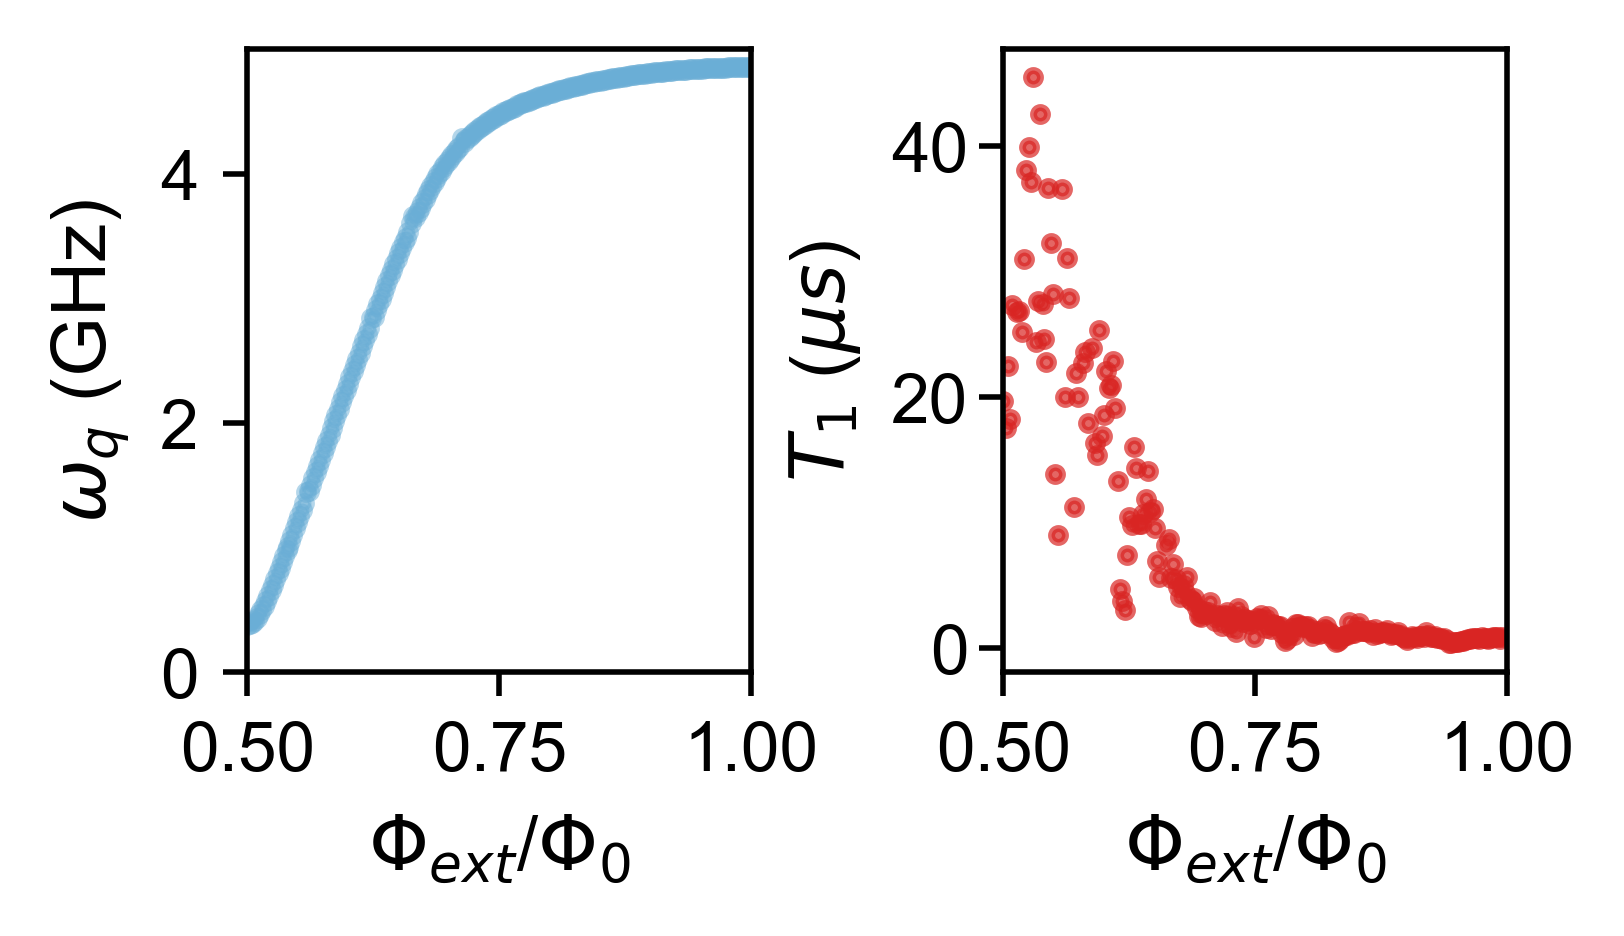

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, dpi=250, sharex=True)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.5, hspace=0.25)
fig.set_size_inches(3.40457, 3.0/2)
font = {'size' : 6}
mpl.rc('font', **font)

ax1.plot(phi_ext_exp, qubit_freq, label = "Experimental", color=cmap_blue(0.5), linestyle='', marker='.', markersize=4)
ax1.set_ylabel(r"$\omega_{q}$ (GHz)")
ax1.set_xlabel(r"$\Phi_{ext}$/$\Phi_{0}$")
ax1.set_xlim(0.5, 1)
ax1.set_ylim(0, 5)

ax2.plot(phi_ext_exp_t1, t1_clean, color=cmap_red(0.7), linestyle='', marker='.', markersize=4)
ax2.set_ylabel(r"$T_{1}$ ($\mu s$)")
ax2.set_xlabel(r"$\Phi_{ext}$/$\Phi_{0}$")
ax2.tick_params(axis='y', pad=1.5)

plt.show()

# Load resonator data

In [9]:
df = pd.read_csv(r'res_fit_results.csv')

#phi_exts
phi_ext_disshift = df['phi_ext_disshift'].to_numpy()
phi_ext_disshift = phi_ext_disshift[~np.isnan(phi_ext_disshift)]

#resonator frequencies (GHz)
#qubit prepared in |0>
frs_0_all = df['fr_q0'].to_numpy()
frs_0_all = frs_0_all[~np.isnan(frs_0_all)]
#qubit prepared in |1>
frs_1_all = df['fr_q1'].to_numpy()
frs_1_all = frs_1_all[~np.isnan(frs_1_all)]

#chi (MHz)
chi = df['chi'].to_numpy()
chi = chi[~np.isnan(chi)]

# Fit with scQubits

## Fluxonium (bare)
get initial guesses

In [10]:
def bare_fluxonium(flux, EJ, EC, EL):
    fluxonium = scq.Fluxonium(
        EJ=EJ,
        EC=EC,
        EL=EL,
        flux=flux,
        cutoff=100,
    )
    evals = fluxonium.get_spectrum_vs_paramvals('flux', flux).energy_table
    return evals[:, 1] - evals[:, 0]

In [11]:
popt_qub, _ = scipy.optimize.curve_fit(
    bare_fluxonium,
    phi_ext_exp,
    qubit_freq,
    p0=(4, 1, 1),
    bounds=(0, 10),
)
print("Success")

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

Success


In [12]:
fitted_fx = bare_fluxonium(phi_ext_exp, *popt_qub)

Ej_init = popt_qub[0]
Ec_init = popt_qub[1]
El_init = popt_qub[2]

Spectral data:   0%|          | 0/219 [00:00<?, ?it/s]

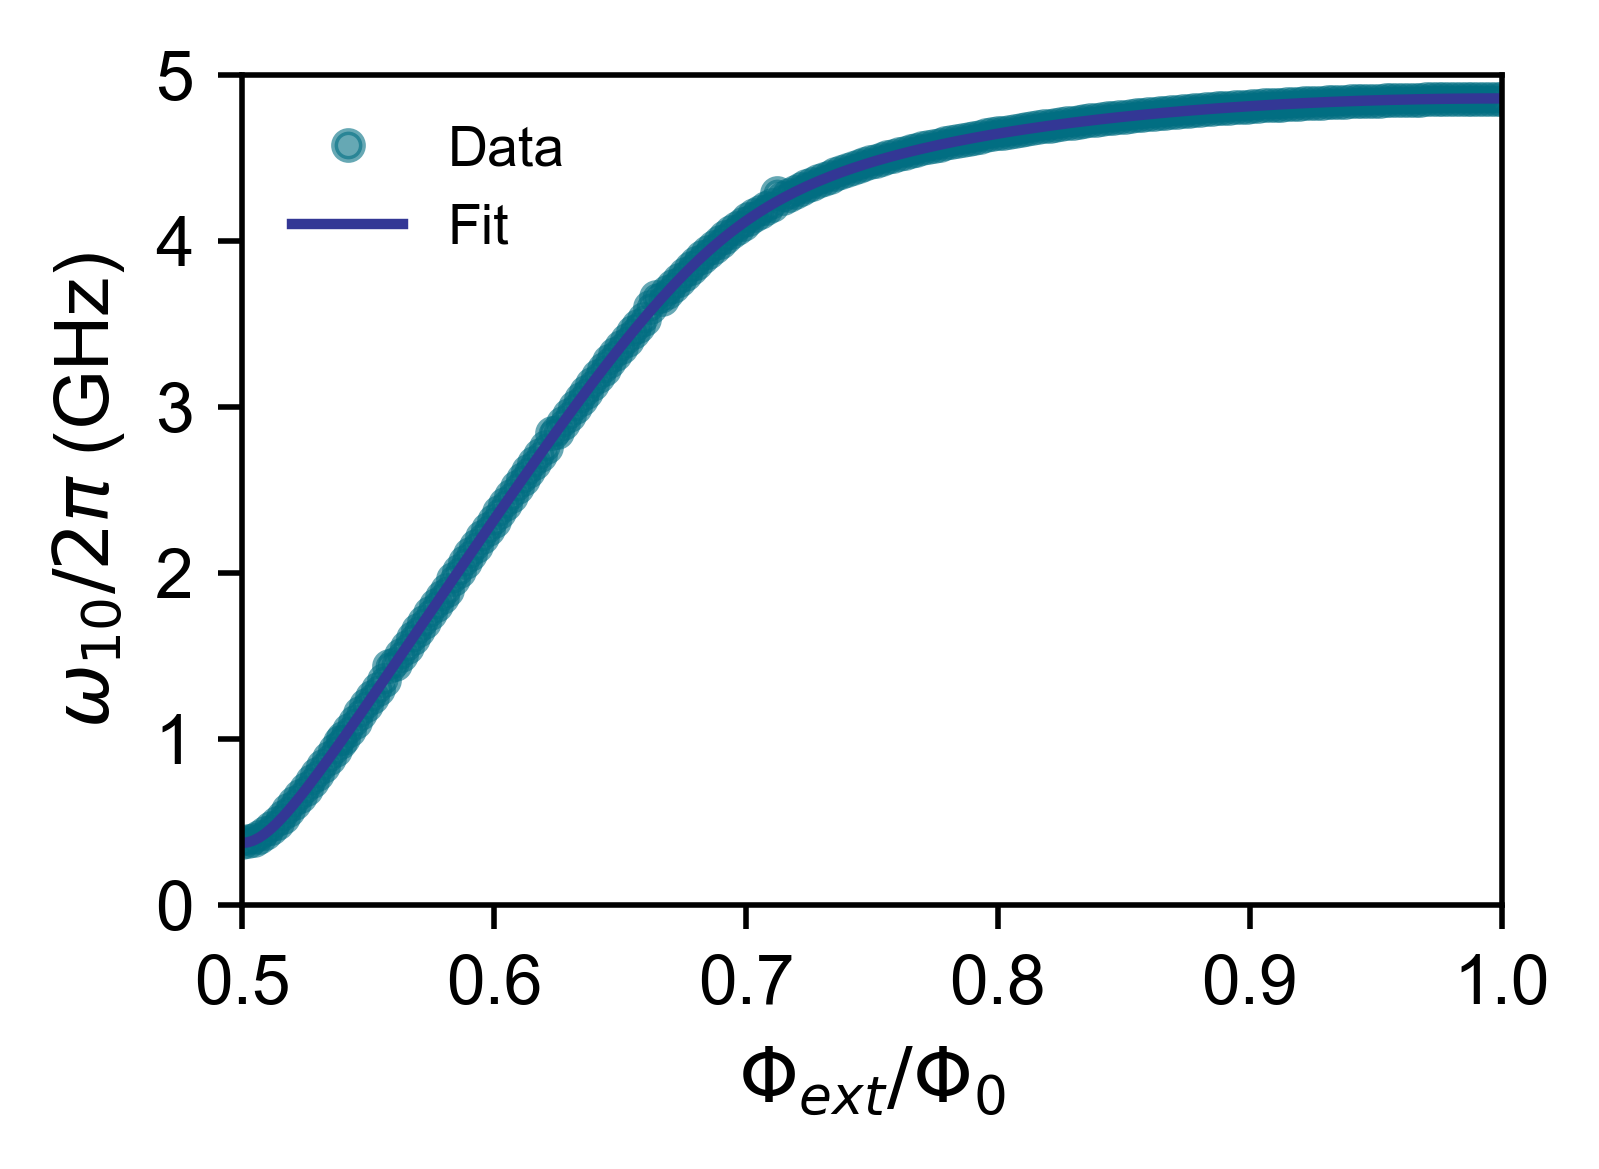

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

ax.plot(phi_ext_exp, qubit_freq, linestyle='', marker='.', markersize=8, alpha=0.6, label='Data')
ax.plot(phi_ext_exp, fitted_fx, ls='-', label='Fit')

ax.set_xlim(0.5, 1)
ax.set_ylim(0,5)

ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"$\omega_{10}/2\pi$ (GHz)")
ax.legend(frameon=False)

## Combined qubit-resonator system

In [14]:
def build_hilbertspace(E_osc, g, EJ, EC, EL):
    
    fx = scq.Fluxonium(
        EJ=EJ,
        EC=EC,
        EL=EL,
        flux=0,
        cutoff=100,
        id_str='fluxonium',
    )
    
    res = scq.Oscillator(
        E_osc=E_osc,
        l_osc=1.0,
        truncated_dim=6,
        id_str='resonator',
    )
    
    phi0 = (8*EC/EL)**(1/4)
    fx_n_operator = fx.n_operator()
    fx_phi_operator = fx.phi_operator()
    fx_annihilation = (1j*phi0/np.sqrt(2))*fx_n_operator + (1/(phi0*np.sqrt(2)))*fx_phi_operator
    
    hilbertspace = scq.HilbertSpace([fx, res])
    hilbertspace.add_interaction(
        g=g,
        op1=(fx_annihilation, fx),
        op2=res.creation_operator,
        add_hc=True,
    )

    return hilbertspace

def dressed_resonator_fres(flux, E_osc, g, EJ=None, EC=None, EL=None):  
    if EJ is None:
        EJ = popt_qub[0] if 'popt_qub' in globals() else 4.75
    if EC is None:
        EC = popt_qub[1] if 'popt_qub' in globals() else 1
    if EL is None:
        EL = popt_qub[2] if 'popt_qub' in globals() else 1
    
    hilbertspace = build_hilbertspace(E_osc, g, EJ, EC, EL)
    
    def update_hilbertspace(flux):
        hilbertspace.subsys_by_id_str('fluxonium').flux = flux
    sweep = scq.ParameterSweep(
        hilbertspace,
        paramvals_by_name=dict(flux=flux),
        update_hilbertspace=update_hilbertspace,
    )

    fres_pred = sweep.transitions(initial=(0,0), final=(0,1), as_specdata=True).energy_table.squeeze()

    return fres_pred

def fx_res_freqs(flux, E_osc, g, EJ, EC, EL):
    hilbertspace = build_hilbertspace(E_osc, g, EJ, EC, EL)
    
    def update_hilbertspace(flux):
        hilbertspace.subsys_by_id_str('fluxonium').flux = flux
    sweep = scq.ParameterSweep(
        hilbertspace,
        paramvals_by_name=dict(flux=flux),
        update_hilbertspace=update_hilbertspace,
    )
    
    fqub_pred = sweep.transitions(initial=(0,0), final=(1,0), as_specdata=True).energy_table.squeeze()
    fres_pred = sweep.transitions(initial=(0,0), final=(0,1), as_specdata=True).energy_table.squeeze()

    # XXX: Hacky
    fqub_pred = fqub_pred[:len(phi_ext_exp)]
    fres_pred = fres_pred[len(phi_ext_exp):]

    return np.concatenate([fqub_pred, fres_pred])

### Dressed resonator
fluxonium parameters fixed based on bare fluxonium fit parameters

In [15]:
popt_res, _ = scipy.optimize.curve_fit(
    dressed_resonator_fres,
    phi_ext_disshift,
    frs_0_all,
    p0=(5.175, 0.2),
)
print("Success")

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

Success


In [16]:
fitted_res = dressed_resonator_fres(phi_ext_disshift, *popt_res, Ej_init, Ec_init, El_init)
fres_0 = popt_res[0]
g_0 = popt_res[1]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/217 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/217 [00:00<?, ?it/s]

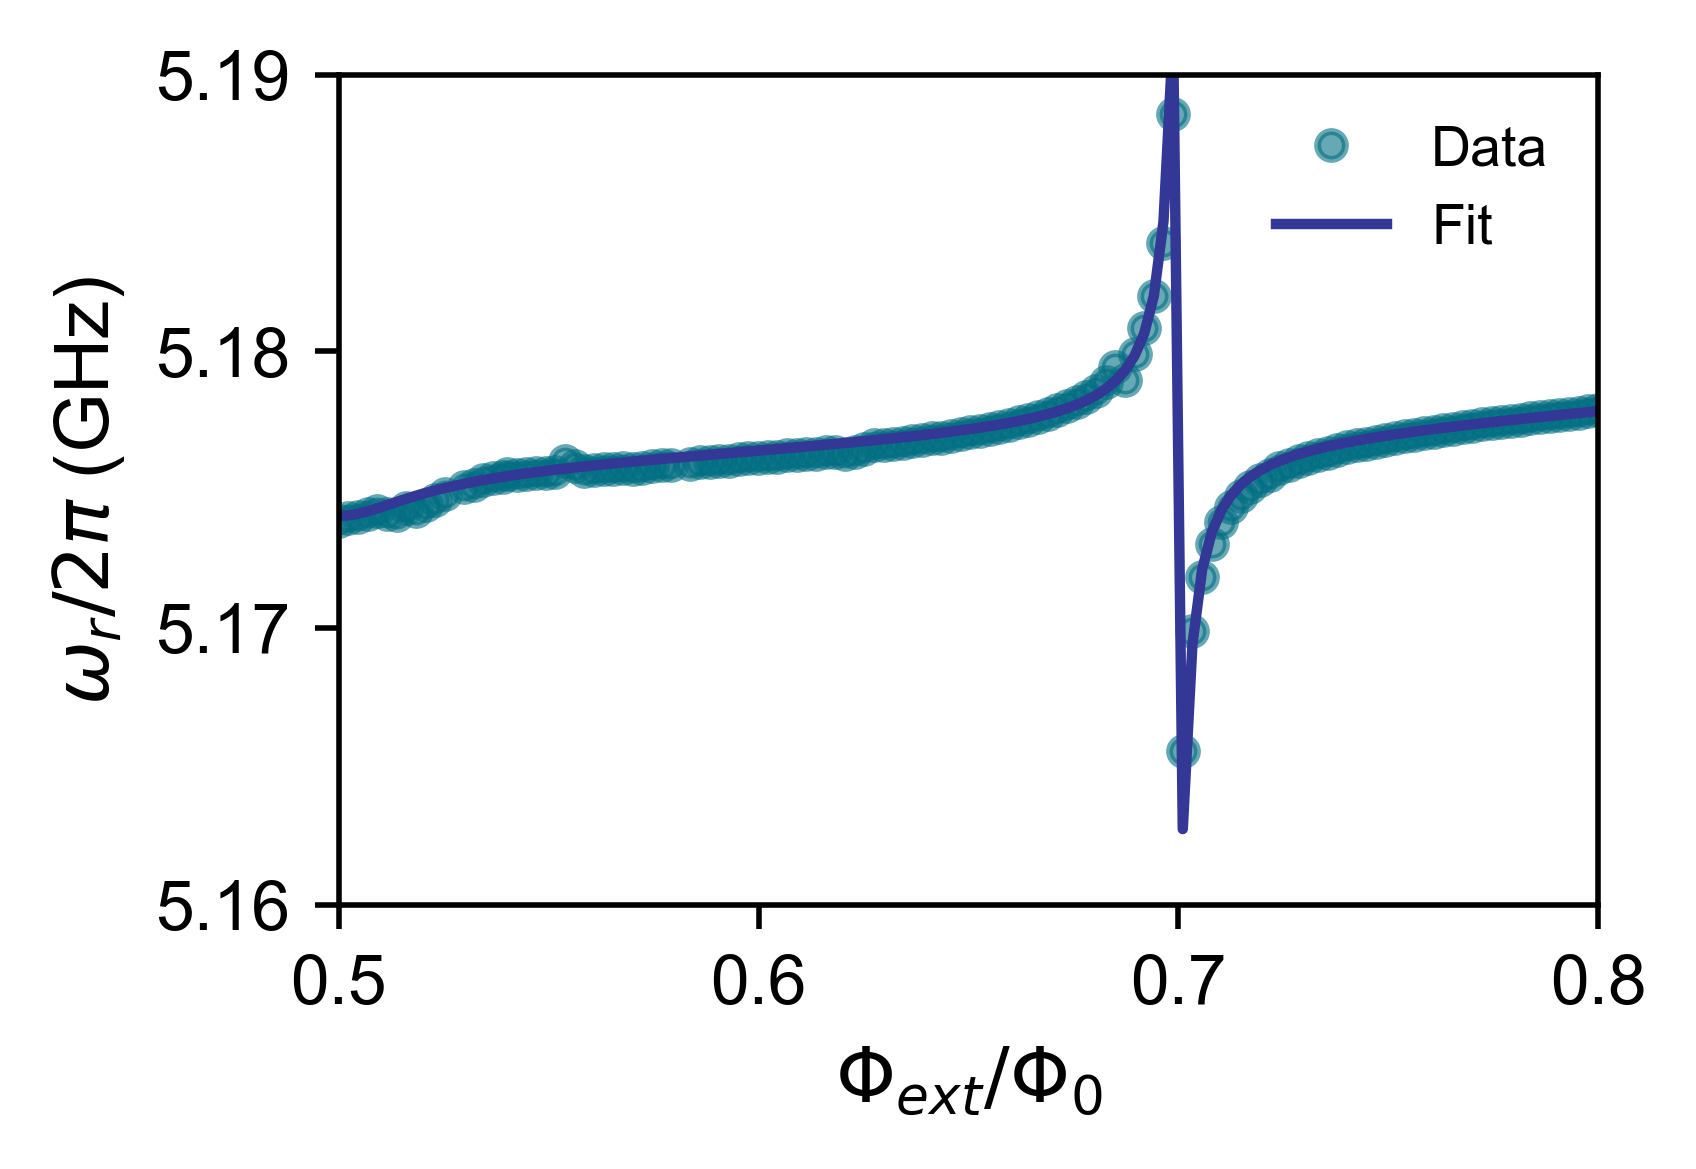

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

ax.plot(phi_ext_disshift, frs_0_all, linestyle='', marker='.', markersize=8, alpha=0.6, label='Data')
ax.plot(phi_ext_disshift, fitted_res, ls='-', label='Fit')

ax.set_xlim(0.5, 0.8)
ax.set_ylim(5.16, 5.19)

ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"$\omega_{r}/2\pi$ (GHz)")
ax.legend(frameon=False)

### Complete dressed system

In [18]:
popt, pcov = scipy.optimize.curve_fit(
    fx_res_freqs,
    np.concatenate([phi_ext_exp, phi_ext_disshift]),
    np.concatenate([qubit_freq, frs_0_all]),
    p0=(*popt_res, *popt_qub),
    sigma=[*(1e-5,)*len(qubit_freq), *(1e-5,)*len(frs_0_all)],
    xtol=1e-3,
)

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/436 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/436 [00:00<?, ?it/s]

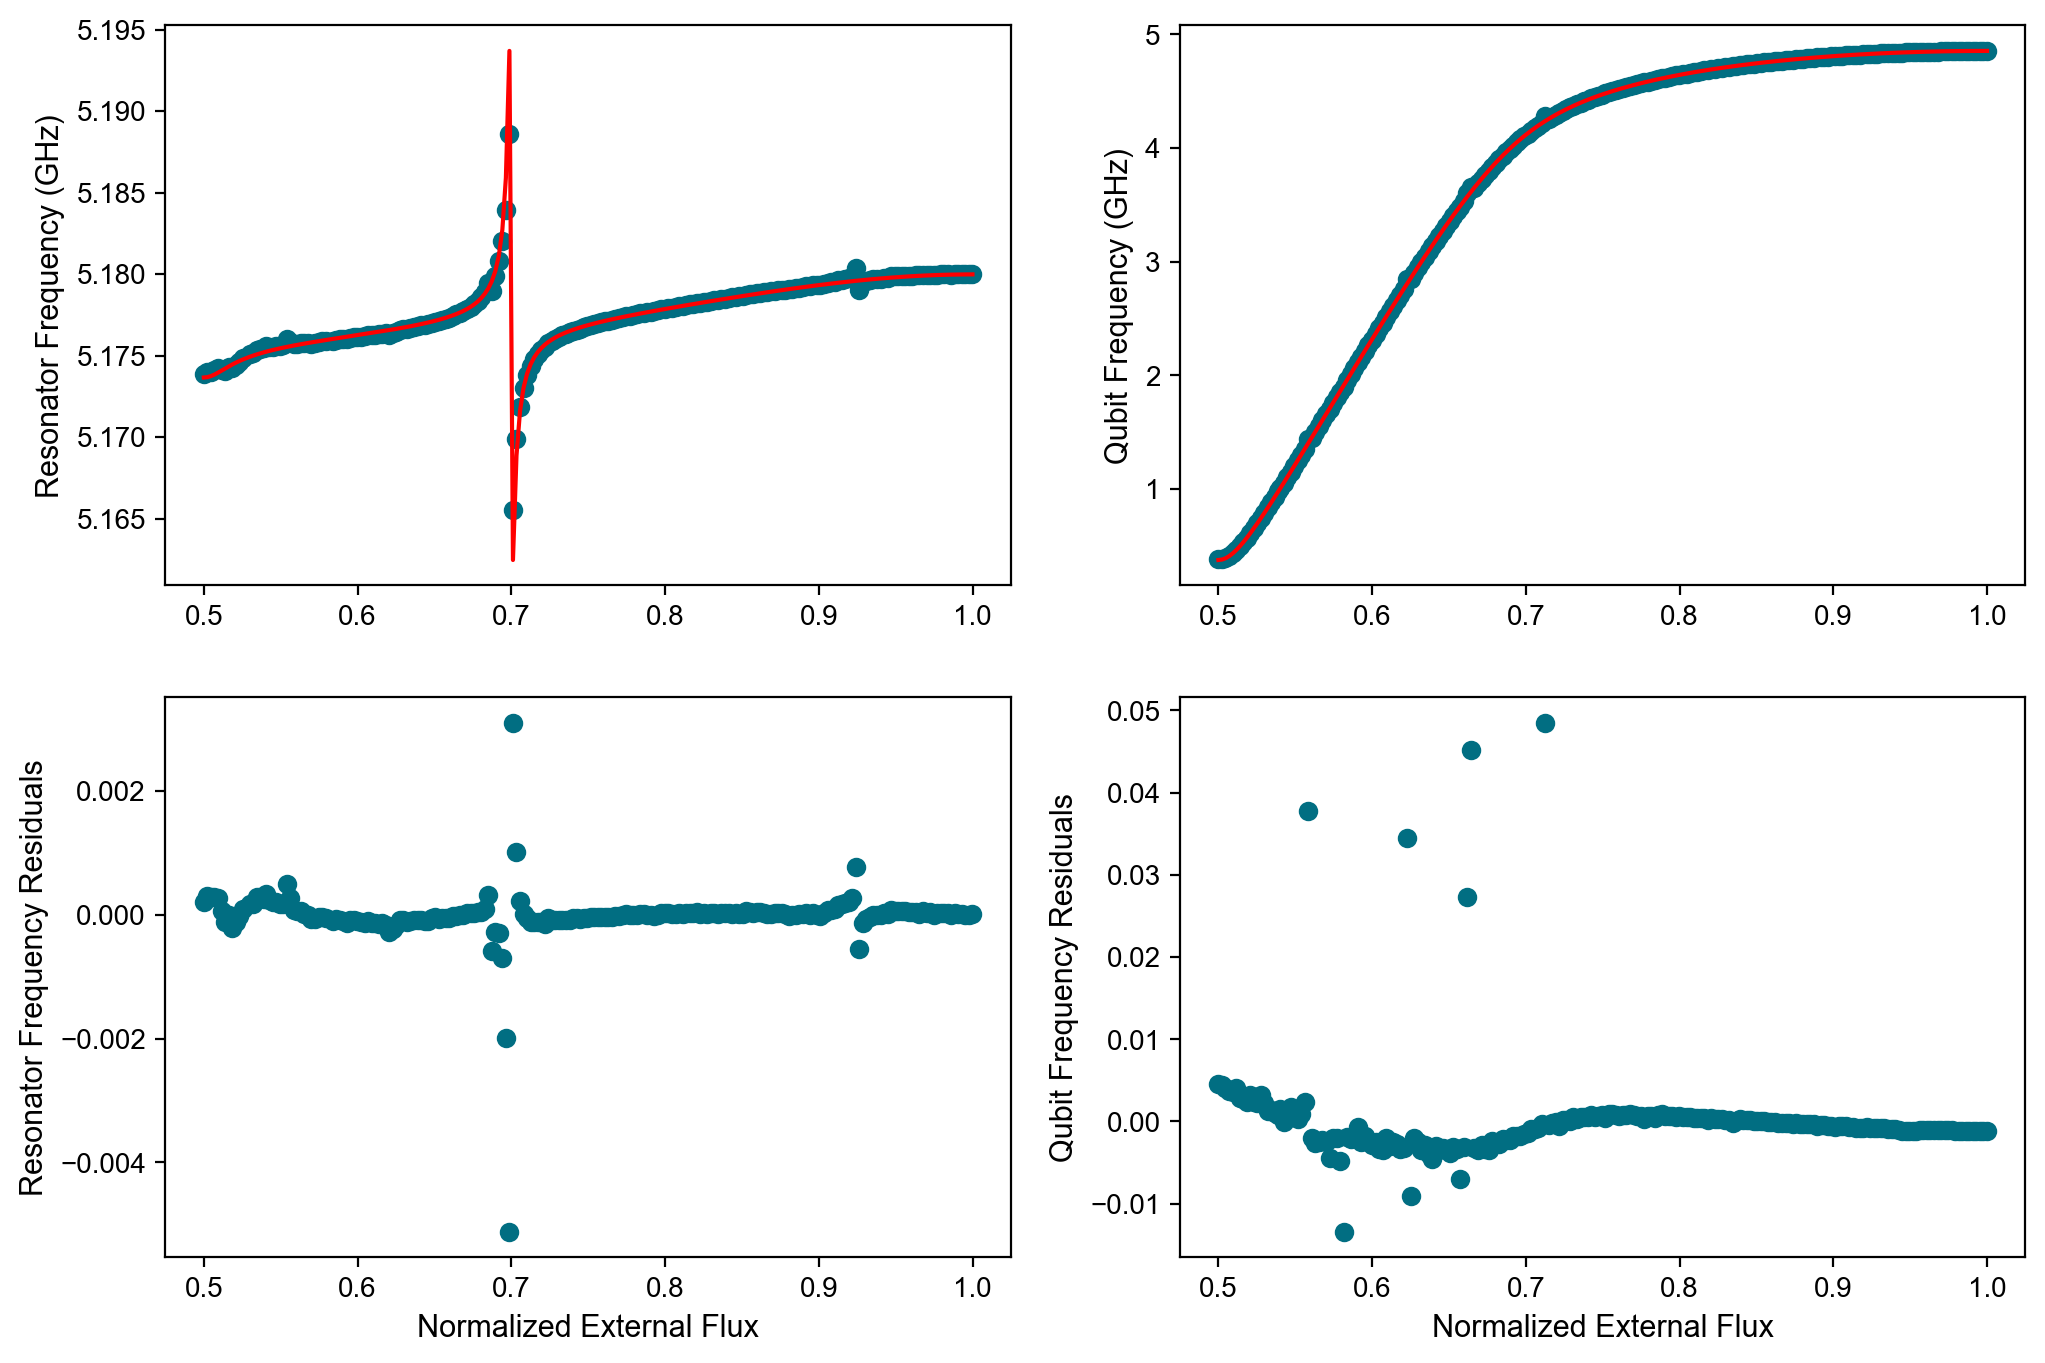

In [19]:
all_pred = fx_res_freqs(
    np.concatenate([phi_ext_exp, phi_ext_disshift]),
    *popt,
)
fqub_pred = all_pred[:len(phi_ext_exp)]
fres_pred = all_pred[len(phi_ext_exp):]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axa = axs[0,0]
axb = axs[0,1]
axc = axs[1,0]
axd = axs[1,1]

plt.sca(axs[0,0])
axa.set_ylabel('Resonator Frequency (GHz)')
plt.scatter(phi_ext_disshift, frs_0_all)
plt.plot(phi_ext_disshift, fres_pred, c='red')

plt.sca(axs[0,1])
axb.set_ylabel('Qubit Frequency (GHz)')
plt.scatter(phi_ext_exp, qubit_freq)
plt.plot(phi_ext_exp, fqub_pred, c='red')

plt.sca(axs[1,0])
axc.set_ylabel('Resonator Frequency Residuals')
axc.set_xlabel('Normalized External Flux')
plt.scatter(phi_ext_disshift, frs_0_all-fres_pred)

plt.sca(axs[1,1])
axd.set_ylabel('Qubit Frequency Residuals')
axd.set_xlabel('Normalized External Flux')
plt.scatter(phi_ext_exp, qubit_freq - fqub_pred)

# Export data

In [20]:
data = {'phi_ext_qubit': phi_ext_exp,
        'phi_ext_t1': phi_ext_exp_t1,
        'T1': t1_clean,
        'qubit_freq': qubit_freq,
        'energy_params': popt,
       }